<a href="https://colab.research.google.com/github/bishair/Real-time-model/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries for the model and plotting
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from math import sqrt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Upload excel file
uploaded = files.upload()

Saving processedCSV.csv to processedCSV.csv


In [ ]:
#Load data into pandas dataframe
df = pd.read_csv('processedCSV.csv', sep=';', decimal=',')

In [ ]:
df.head()

,DateGW,G10,RiverLevel
0,2015-01-30 13:00:00,8.555,260
1,2015-01-30 14:00:00,8.557,260
2,2015-01-30 15:00:00,8.559,260
3,2015-01-30 16:00:00,8.562,260
4,2015-01-30 17:00:00,8.563,260


In [ ]:
# Convert 'DateGW' to datetime and set as index
df['DateGW'] = pd.to_datetime(df['DateGW'])
df.set_index('DateGW', inplace=True)

In [ ]:
# Columns to scale
data = df[['G10', 'RiverLevel']].values

In [ ]:
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
# Prepare the data for LSTM
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i, 0])  # 0 for G10 groundwater level at current time
    return np.array(X), np.array(y)


In [ ]:
sequence_length = 24  # Look 24 hours back to predict the next hour
X, y = create_dataset(scaled_data, sequence_length)

In [ ]:
# Reshape features for LSTM Layer [samples, time steps, features]
X = np.reshape(X, (X.shape[0], sequence_length, X.shape[2]))

In [ ]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # predicting one value

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, validation_split=0.1)

Epoch 1/100
173/173 [==============================] - 7s 22ms/step - loss: 0.0235 - val_loss: 1.7823e-04
Epoch 2/100
173/173 [==============================] - 3s 15ms/step - loss: 8.6403e-05 - val_loss: 1.2778e-04
Epoch 3/100
173/173 [==============================] - 3s 15ms/step - loss: 7.2334e-05 - val_loss: 1.2725e-04
Epoch 4/100
173/173 [==============================] - 3s 15ms/step - loss: 6.0439e-05 - val_loss: 1.0725e-04
Epoch 5/100
173/173 [==============================] - 4s 22ms/step - loss: 4.9569e-05 - val_loss: 8.5254e-05
Epoch 6/100
173/173 [==============================] - 3s 15ms/step - loss: 4.0816e-05 - val_loss: 5.7540e-05
Epoch 7/100
173/173 [==============================] - 2s 14ms/step - loss: 3.3966e-05 - val_loss: 5.1190e-05
Epoch 8/100
173/173 [==============================] - 3s 15ms/step - loss: 2.8835e-05 - val_loss: 3.5723e-05
Epoch 9/100
173/173 [==============================] - 3s 15ms/step - loss: 2.4282e-05 - val_loss: 3.3818e-05
Epoch 10/100
1

In [ ]:
model.save('my_lstm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Predictions
predicted_groundwater_level = model.predict(X_test)

165/165 [==============================] - 1s 6ms/step


In [ ]:
# Inverse transform the normalized values to the original scale
predicted_groundwater_level = scaler.inverse_transform(np.hstack((predicted_groundwater_level, np.zeros((predicted_groundwater_level.shape[0], scaled_data.shape[1]-1)))))
y_test = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1]-1)))))[:, 0]

In [ ]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test, predicted_groundwater_level[:, 0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.005


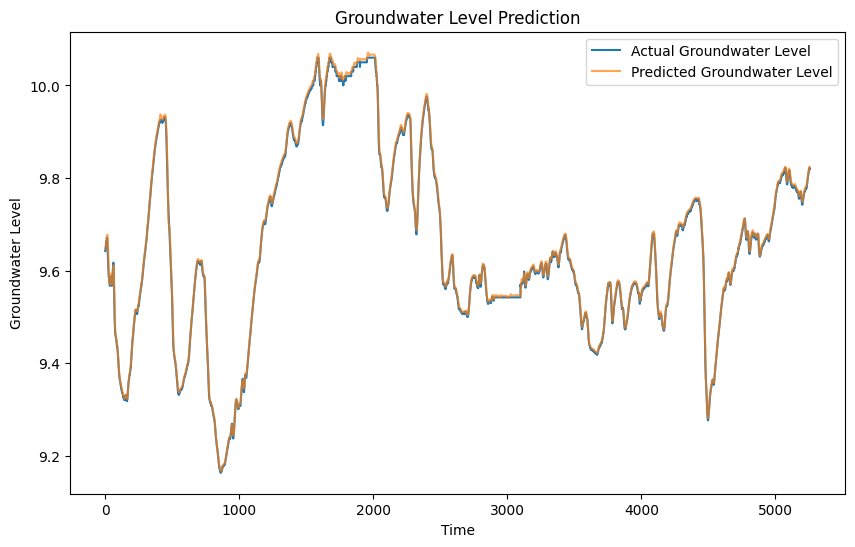

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Groundwater Level')
plt.plot(predicted_groundwater_level[:, 0], label='Predicted Groundwater Level', alpha=0.7)
plt.title('Groundwater Level Prediction')
plt.xlabel('Time')
plt.ylabel('Groundwater Level')
plt.legend()
plt.show()

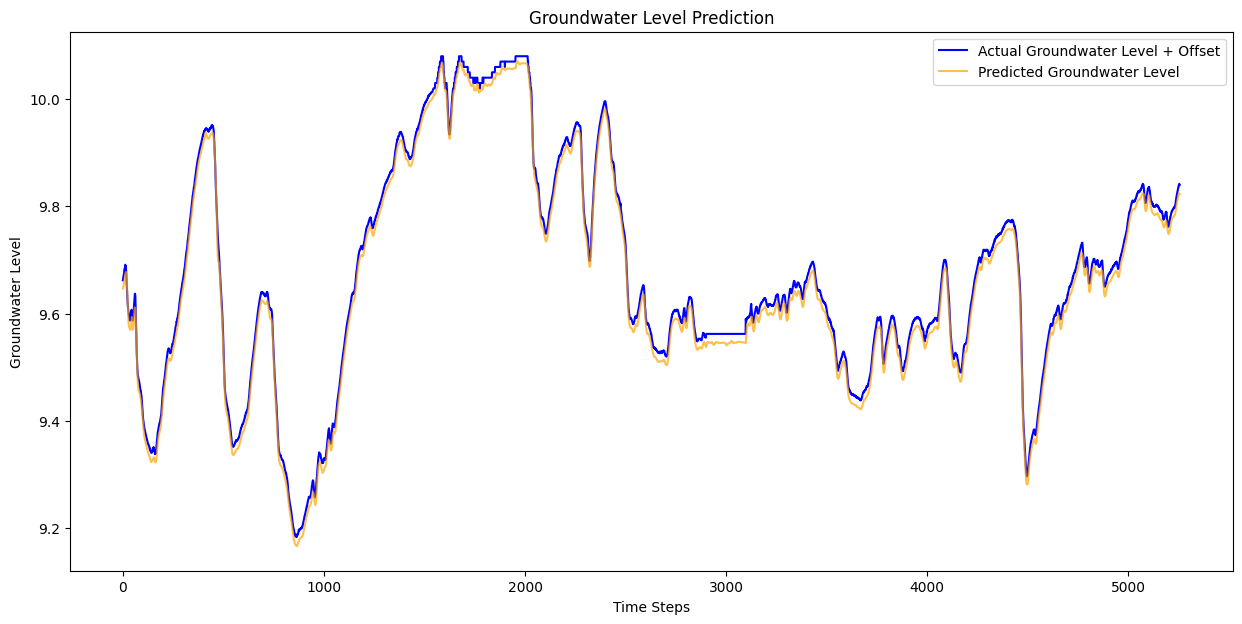

In [ ]:
# Plot the actual vs predicted values with a slight offset
plt.figure(figsize=(15, 7))
plt.plot(y_test + 0.02, label='Actual Groundwater Level + Offset', color='blue')  # Offset added for visibility
plt.plot(predicted_groundwater_level[:, 0], label='Predicted Groundwater Level', color='orange', alpha=0.7)
plt.title('Groundwater Level Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Groundwater Level')
plt.legend()
plt.show()

Epoch 1/100
173/173 [==============================] - 3s 15ms/step - loss: 2.0942e-06 - val_loss: 1.9103e-06
Epoch 2/100
173/173 [==============================] - 2s 14ms/step - loss: 2.5010e-06 - val_loss: 2.9725e-06
Epoch 3/100
173/173 [==============================] - 3s 15ms/step - loss: 2.2295e-06 - val_loss: 1.5063e-06
Epoch 4/100
173/173 [==============================] - 3s 16ms/step - loss: 2.5691e-06 - val_loss: 5.3828e-06
Epoch 5/100
173/173 [==============================] - 4s 21ms/step - loss: 2.2154e-06 - val_loss: 2.1458e-06
Epoch 6/100
173/173 [==============================] - 2s 14ms/step - loss: 1.5772e-06 - val_loss: 3.1696e-06
Epoch 7/100
173/173 [==============================] - 2s 14ms/step - loss: 2.2970e-06 - val_loss: 2.2843e-06
Epoch 8/100
173/173 [==============================] - 2s 14ms/step - loss: 1.7248e-06 - val_loss: 1.4756e-06
Epoch 9/100
173/173 [==============================] - 3s 15ms/step - loss: 1.7683e-06 - val_loss: 2.9895e-06
Epoch 10/1

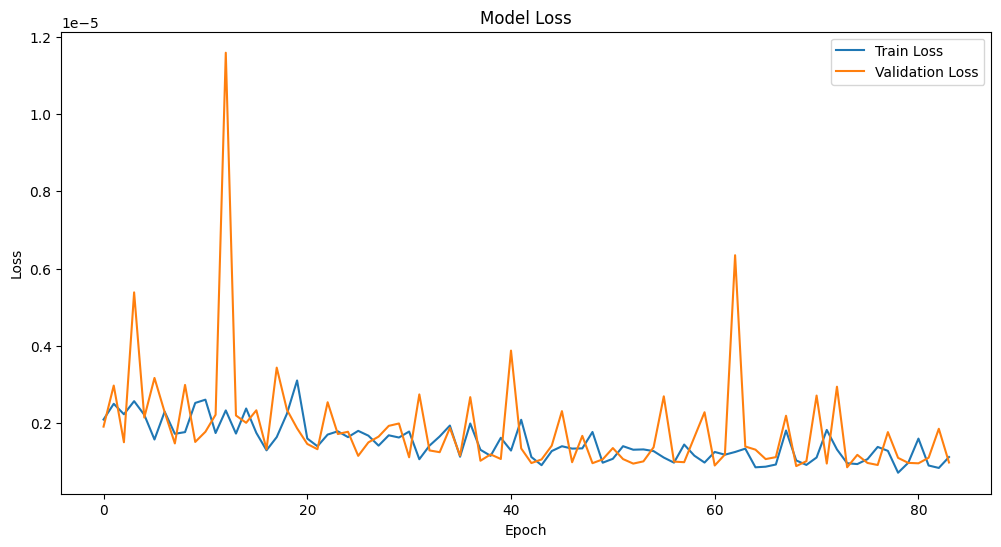

Potential overfitting detected: train loss (7.1803293621997e-07) lower than validation loss (8.587634852119663e-07).


In [ ]:


# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with the early stopping callback
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.1,  # Adjust if you have a separate validation set
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Get the loss values to check for overfitting
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Check for overfitting
if min(train_loss) < min(val_loss):
    print(f"Potential overfitting detected: train loss ({min(train_loss)}) lower than validation loss ({min(val_loss)}).")

# check the final epochs
if train_loss[-1] < val_loss[-1]:
    print(f"Overfitting may be occurring, as the training loss ({train_loss[-1]}) is still lower than the validation loss ({val_loss[-1]}) at the last epoch.")
